# Permutation Tests

With this notebook you can run permutation tests on our pretrained models. It is also possible to train fast new models to run the permutation tests on.

Permutation tests show the importance of a feature in a model. Higher permutation scores show that a features is more important for the model. If the permutation test score is below zero, then the feature has a negative effect on the prediction.

In [1]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import lightgbm as lgb
# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')
import wandb
from wandb.lightgbm import wandb_callback

## Variables

In [2]:
# SEED = 42                        # We want all things
# seed_everything(SEED)            # to be as deterministic 
# lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores
ver='tweedie+timeweights+l1'

#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon
#USE_AUX     = True               # Use or not pretrained models

weight_features = ['Weight','ScalingFactor','CombinedWeight']
# FEATURES to remove: These features lead to overfit or values not present in test set
remove_features = ['id','store_id','state_id',
                   'date','wm_yr_wk','d',TARGET] + weight_features
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

#PATHS for Features
#ORIGINAL = '../input/m5-forecasting-accuracy/'
BASE     = 'grid_part_1.pkl'
PRICE    = 'grid_part_2.pkl'
CALENDAR = 'grid_part_3.pkl'
LAGS     = 'lags_df_28.pkl'
MEAN_ENC = 'mean_encoding_df.pkl'


# AUX(pretrained) Models paths
#AUX_MODELS = '../input/m5-aux-models/'

#STORES ids
STORES_IDS = pd.read_csv('sales_train_validation.csv')['store_id']
STORES_IDS = list(STORES_IDS.unique())

#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])

## Helper Functions

In [3]:
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [4]:
def get_data_by_store(store):
    
    # Read and contact basic feature
    df = pd.concat([pd.read_pickle(BASE),
                pd.read_pickle(PRICE).iloc[:,2:],
                pd.read_pickle(CALENDAR).iloc[:,2:]],
                axis=1)

    # Leave only relevant store
    df = df[df['store_id']==store]
    # With memory limits we have to read 
    # lags and mean encoding features
    # separately and drop items that we don't need.
    # As our Features Grids are aligned 
    # we can use index to keep only necessary rows
    # Alignment is good for us as concat uses less memory than merge.

    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 # to not reach memory limit 

    df = pd.concat([df, df3], axis=1)
    del df3 # to not reach memory limit 
    
    # Create true index ('idd') column
    # df['idd'] = df['id'].str.cat(df['d'],sep="_")

    # Create features list
    weights_df = df[['id','d']+[col for col in list(df) if col in weight_features]]
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d', 'store_id', 'state_id', TARGET]+features]

    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)


    return df, features, weights_df

In [5]:
# Recombine Test set after training
def get_base_test():
    base_test = pd.DataFrame()

    for store_id in STORES_IDS:
        temp_df = pd.read_pickle('test_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
    return base_test

In [6]:
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

## Perform Permutation Tests
To select the propper features, we test the influence of each feature on the performance of a model

In [7]:
## from https://www.kaggle.com/dansbecker/permutation-importance @dansbecker

# Small function to make fast features tests
# estimator = make_fast_test(grid_df)
# it will return lgb booster for future analisys
lgb_params_test = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'None',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**7-1, # bigger for faster training
                    'min_data_in_leaf': 2**8-1, # less generalization, but trains faster
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'early_stopping_rounds': 10, # stop early for fast training
                    'verbose': -1,                   
                }

## WRMSSE
class WRMSSE:
    def __init__(self,weights_df):
        self.weights_df = weights_df

    def eval(self,preds, val_data):
#         The weights and the validation set have the same size

        labels = val_data.get_label() 
        Ws = self.weights_df['Weight'].to_numpy()
        Ss = self.weights_df['ScalingFactor'].to_numpy()
        
        RMSSEs = np.sqrt(np.square(labels - preds)/Ss)
        WRMSEE = np.sum(Ws * RMSSEs)
        
        return 'WRMSSE', WRMSEE, False
    
    def getScore(self,preds, val_data):
#         The weights and the validation set have the same size

        labels = val_data 
        Ws = self.weights_df['Weight'].to_numpy()
        Ss = self.weights_df['ScalingFactor'].to_numpy()
        
        RMSSEs = np.sqrt(np.square(labels - preds)/Ss)
        WRMSEE = np.sum(Ws * RMSSEs)
        
        return WRMSEE

# Train a model fast to perform the permutation tests on
def make_fast_test(df, features_columns, weights_df):
    train_mask = df['d']<=(END_TRAIN-28)
    valid_mask = df['d']>(END_TRAIN-28)
    
    tr_x, tr_y = df[train_mask][features_columns], df[train_mask][TARGET]              
    vl_x, vl_y = df[valid_mask][features_columns], df[valid_mask][TARGET]
    
    weights_df = weights_df.reset_index()
    weighting = dict(zip(np.arange(1,1942), np.arange(1/1941,2,2/1941)))
    time_weights = [weighting[d] for d in df[train_mask]['d']]
    
    train_data = lgb.Dataset(tr_x, label=tr_y, weight=time_weights)
    valid_data = lgb.Dataset(vl_x, label=vl_y)
    
    estimator = lgb.train(
                            lgb_params_test,
                            train_data,
                            valid_sets = [valid_data],
                            verbose_eval = 500,
                            feval = WRMSSE(weights_df[valid_mask]).eval
                        )
    return estimator

# perform permutation tests for all (non categorical) features in the model
def permutation_test(df, features_columns, weights_df, c_id, perm_scores):
    # Let's creat validation dataset
    valid_mask = df['d']>(END_TRAIN-28)
    validation_df = df[valid_mask].reset_index(drop=True)
    weights_df = weights_df.reset_index()
    
    # Read in model
    model_path = 'lgb_model_'+c_id+'_v'+str(ver)+'.bin' 
    model = pickle.load(open(model_path, 'rb'))
    # Make normal prediction with our model and save score
    validation_df['preds'] = model.predict(validation_df[features_columns])
    base_score = WRMSSE(weights_df[valid_mask]).getScore(validation_df['preds'], validation_df[TARGET])
    print('Standart WRMSSE', base_score)

    # Now we are looping over all our numerical features
    for col in features_columns:

        # We will make validation set copy to restore
        # features states on each run
        temp_df = validation_df.copy()

        # Error here appears if we have "categorical" features and can't 
        # do np.random.permutation without disrupt categories
        # so we need to check if feature is numerical
        if temp_df[col].dtypes.name != 'category':
            temp_df[col] = np.random.permutation(temp_df[col].values)
            temp_df['preds'] = model.predict(temp_df[features_columns])
            cur_score = WRMSSE(weights_df[valid_mask]).getScore(temp_df['preds'], temp_df[TARGET])

            # If our current rmse score is less than base score
            # it means that feature most probably is a bad one
            # and our model is learning on noise
            print(col, np.round(cur_score - base_score, 4))
            perm_scores[c_id][col] = cur_score - base_score

    # Remove Temp data
    del temp_df, validation_df
    return perm_scores

# Perform the whole permutation test cycle for multiple model
def all_permutation_tests(column_ids):
    # initialize permutation scores matrix
    grid_df, features_columns, weights_df = get_data_by_store(column_ids[0])
    perm_scores = np.zeros((len(features_columns), len(column_ids)))
    perm_scores = pd.DataFrame(perm_scores, columns=column_ids, index=features_columns)

    for c_id in column_ids:
        print('Fast_test', c_id)

        # Get data grid of current store
        if (c_id!=column_ids[0]):
            grid_df, features_columns, weights_df = get_data_by_store(c_id)
        print('  Data is loaded')
        
        ## needed when you do not have a pretrained model to perform permutation tests on
        # train a model fast
        #model = make_fast_test(grid_df, features_columns, weights_df)
        #print('  Model is created')
        
        # compute the permutation scores
        print('  Permutation test performance:')
        perm_scores = permutation_test(grid_df, features_columns, weights_df, c_id, perm_scores)
        print('  Permutation test is finished\n')
        
    # compute average permutation scores over all trained models and return scores
    perm_scores['average'] = perm_scores.mean(numeric_only=True, axis=1)
    return perm_scores

In [8]:
# Run permutation tests for all models and save results in a file
perm_scores = all_permutation_tests(STORES_IDS)
perm_csv_name = 'permutation_scores_stores_v'+str(ver)+'.csv'
perm_scores.to_csv(perm_csv_name)

## Feature Importance Plots

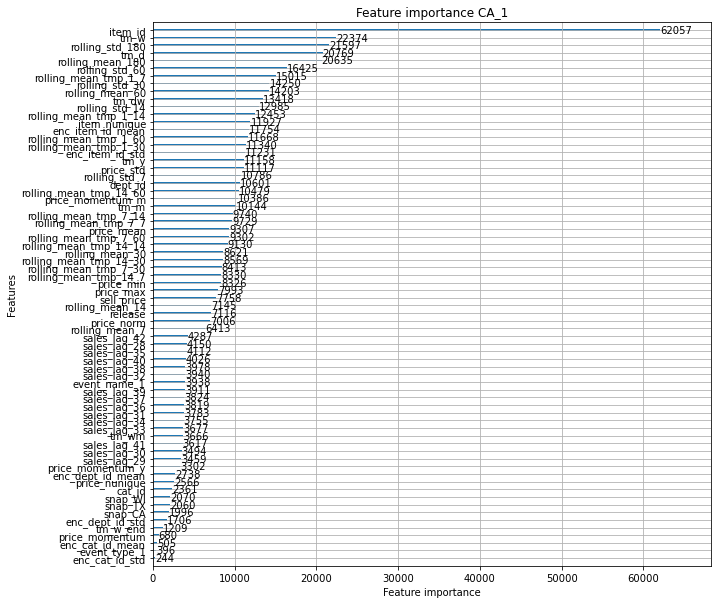

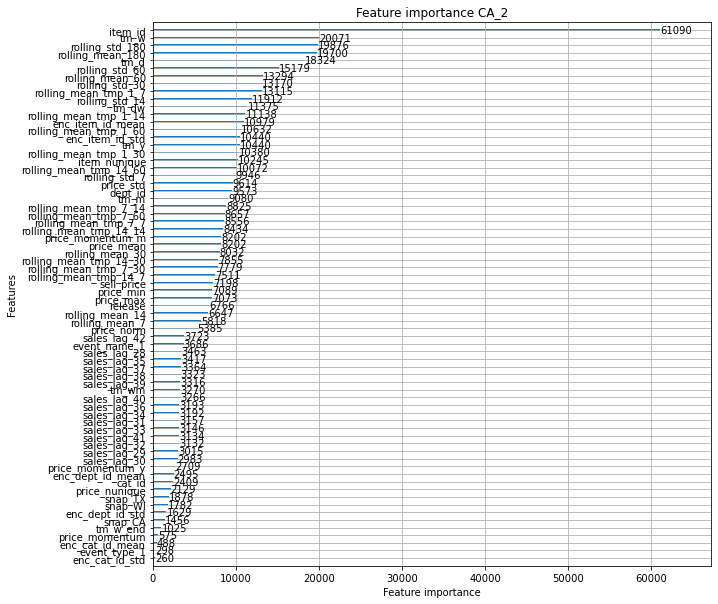

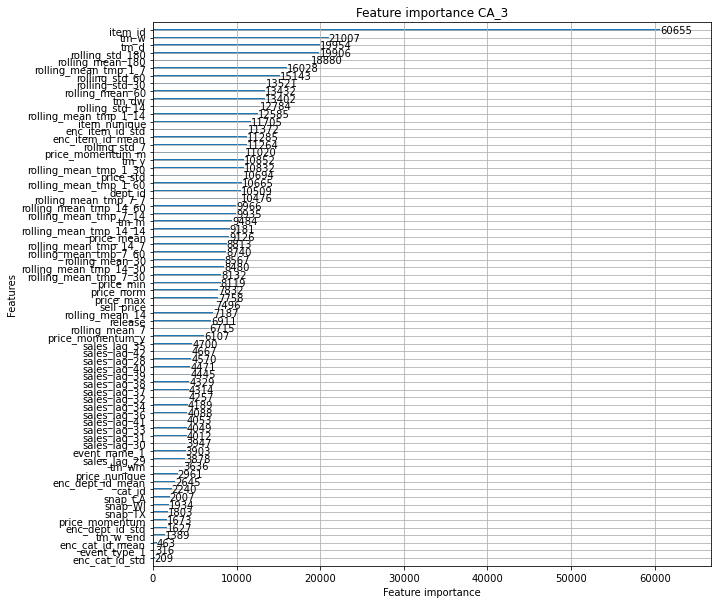

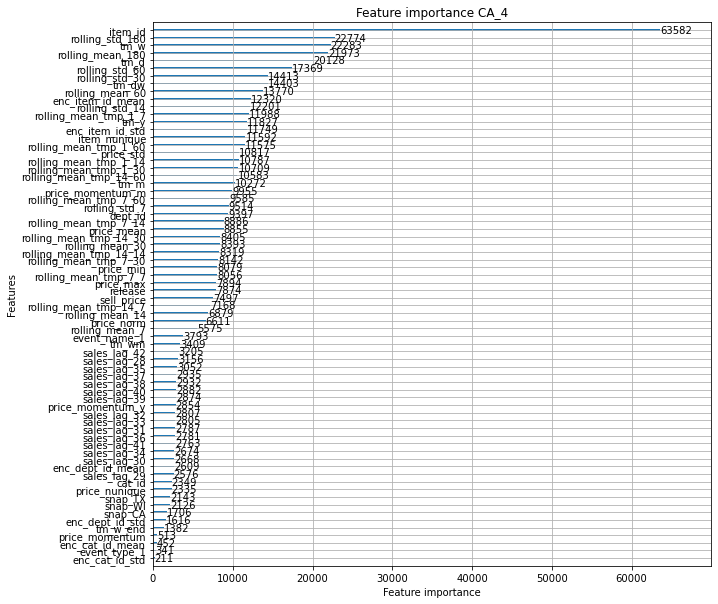

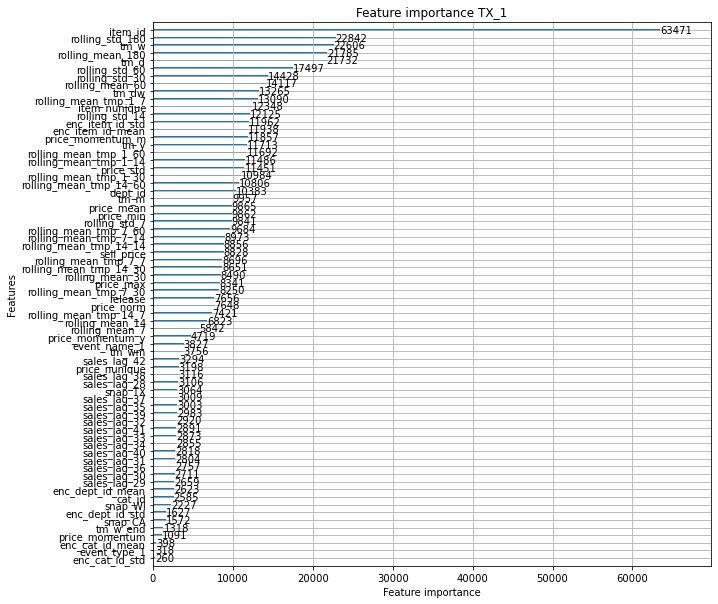

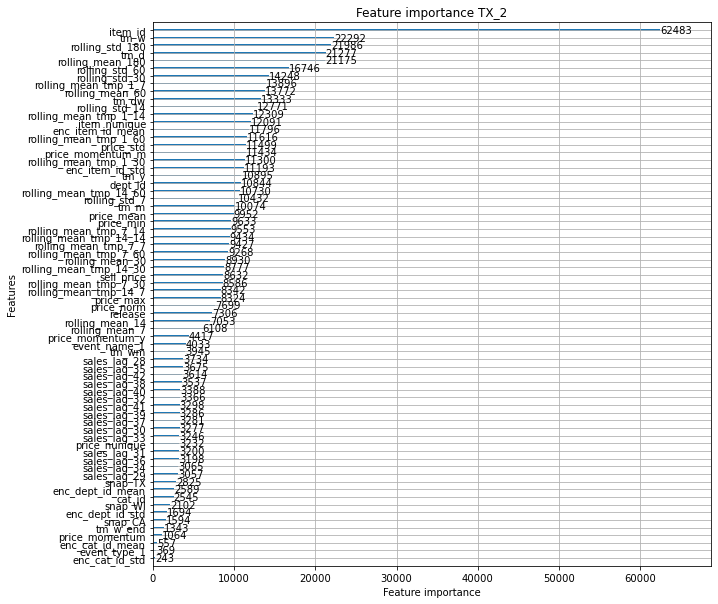

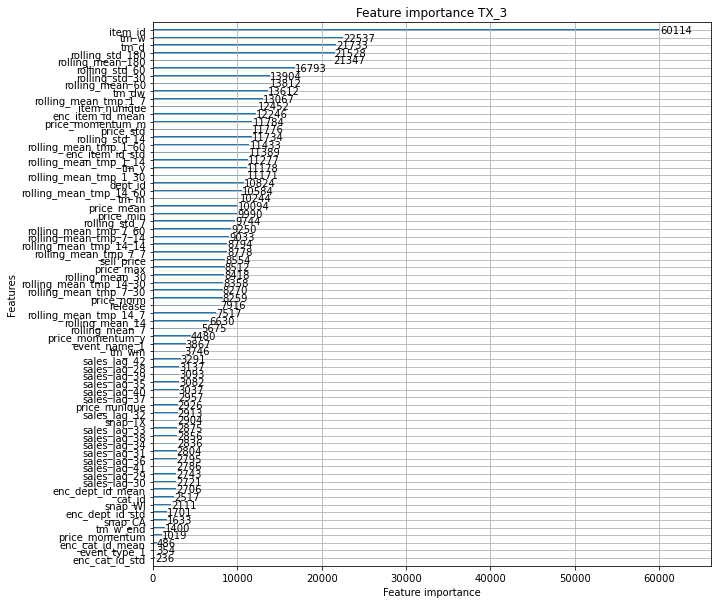

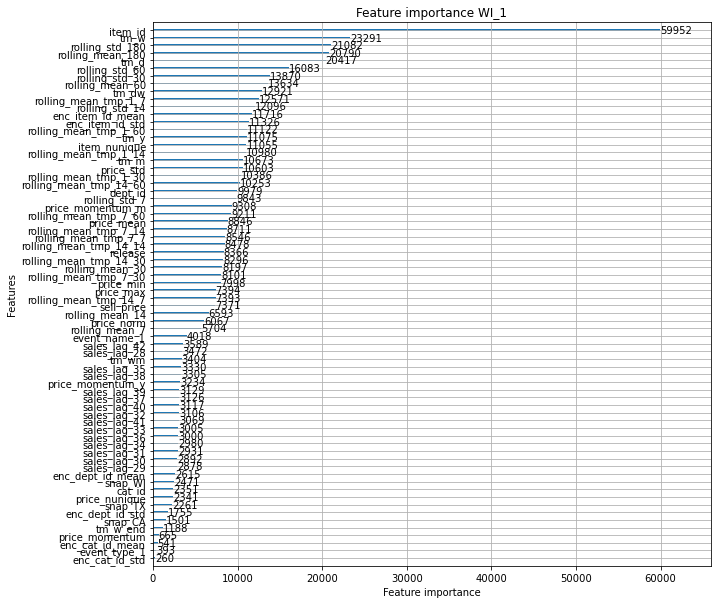

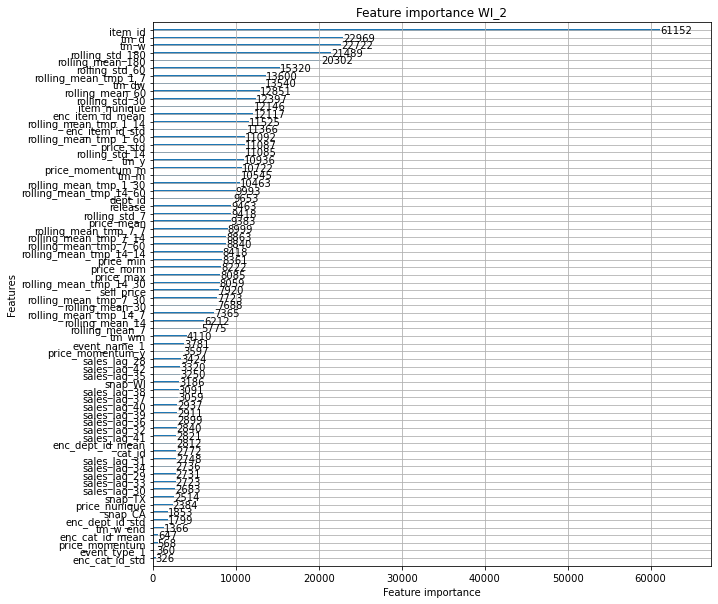

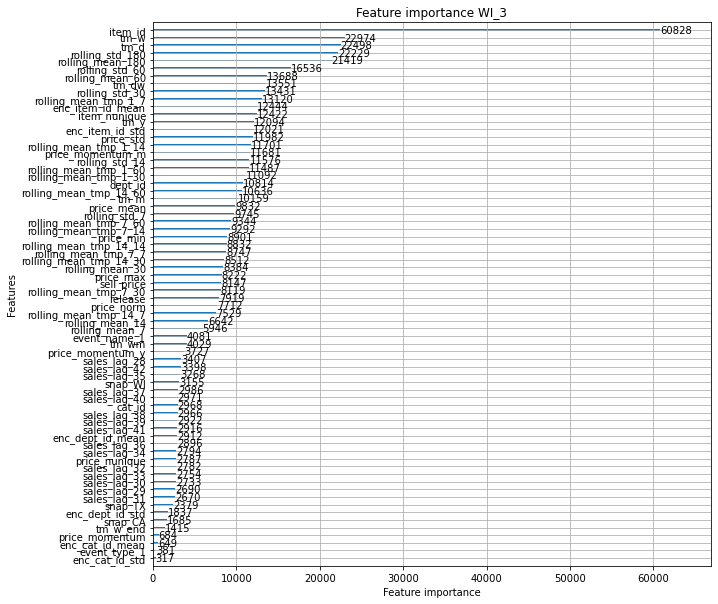

In [13]:
# Plot features importance plots for all models
for s_id in STORES_IDS:
    model_path = 'lgb_model_'+s_id+'_v'+str(ver)+'.bin' 
    model = pickle.load(open(model_path, 'rb'))
    ax = lgb.plot_importance(model, figsize=(10,10), title='Feature importance '+s_id)
    ax.figure.savefig('Feature_importance/fi_'+s_id+'.png')